# Group 12 - Strategy Implementation and Backtesting

## 0. Import packages

If there are any missing packages, you can install them by typing in the code shell:
```terminal
!pip install <package_name>
```
or
```terminal
%pip install <package_name>
```

In [ ]:
import pandas as pd
import numpy as np
import psycopg
import json
import pprint
import mplfinance as mpf

from typing import List
from matplotlib import pyplot as plt
from numpy.testing import assert_almost_equal, assert_equal

## 1. Data Preparation
### 1.1. Data Importing
First, we load the data from `yfinance`:

In [ ]:
# Load data
with open('database.json', 'rb') as fb:
    db_info = json.load(fb)
conn = psycopg.connect(
    host=db_info['host'],
    port=db_info['port'],
    dbname=db_info['database'],
    user=db_info['user'],
    password=db_info['password']
)
with psycopg.connect(
    host=db_info['host'],
    port=db_info['port'],
    dbname=db_info['database'],
    user=db_info['user'],
    password=db_info['password']
) as conn:
    # Open a cursor to perform database operations
    with conn.cursor() as data:
        
        # Execute a query
        data.execute("""
            SELECT m.datetime, m.tickersymbol, m.price
            FROM "quote"."matched" m
            WHERE m.tickersymbol = 'VN30F2301'
            AND m.datetime > '2022-12-31 21:00:00'
        """)

        # Use fetchall() to get all the data of the query.
        # Note: fetchall() can be costly and inefficient.
        # Other efficient ways have been discussed extensively on the Internet. Or you can ask ChatGPT ;)
        dataset = data.fetchall()

        # Print the total number of ticks of that day
        print(f'Total number of tick: {len(dataset)}')

        # Pretty print the first five ticks

In [ ]:
# Devide data into in-sample and out-sample
in_sample_dataset = dataset[:int(len(dataset)*0.8)]
out_sample_dataset = dataset[int(len(dataset)*0.8):]

# Chuyển dữ liệu sang DataFrame của in_sample_data
in_sample_candle = pd.DataFrame(in_sample_dataset, columns=['datetime', 'tickersymbol', 'price'])
in_sample_candle['price'] = pd.to_numeric(in_sample_candle['price'], errors='coerce')
print(in_sample_candle['price'].dtype)

# Chuyển đổi cột datetime về kiểu datetime
in_sample_candle['datetime'] = pd.to_datetime(in_sample_candle['datetime'])
in_sample_candle.set_index('datetime', inplace=True)
# sort by datetime
in_sample_candle.sort_index(inplace=True)

print(in_sample_candle[:50])

# Resample dữ liệu theo khung 1 giờ (1h)
in_sample_candle_ohlc = in_sample_candle['price'].resample('1t').ohlc()

# Vẽ biểu đồ nến
mpf.plot(in_sample_candle_ohlc[5:100], type='candle', style='charles',
        title=" In sample data VN30F2311 Candlestick Chart (1h)", ylabel="Price")

# Chuyển dữ liệu sang DataFrame của in_sample_data
out_sample_candle = pd.DataFrame(out_sample_dataset, columns=['datetime', 'tickersymbol', 'price'])
out_sample_candle['price'] = pd.to_numeric(out_sample_candle['price'], errors='coerce')
print(out_sample_candle['price'].dtype)
# Chuyển đổi cột datetime về kiểu datetime
out_sample_candle['datetime'] = pd.to_datetime(out_sample_candle['datetime'])
out_sample_candle.set_index('datetime', inplace=True)

# Resample dữ liệu theo khung 1 giờ (1h)
out_sample_candle_ohlc = out_sample_candle['price'].resample('5t').ohlc()

# Vẽ biểu đồ nến
# mpf.plot(out_sample_candle_ohlc[-50:], type='candle', volume=True, style='charles',
#         title=" Out sample data VN30F2311 Candlestick Chart (1h)", ylabel="Price", ylabel_lower="Volume")

print(len(in_sample_candle_ohlc), len(out_sample_candle_ohlc))
print(in_sample_candle_ohlc[0:50])
print(out_sample_candle_ohlc[-10:])

## 2. Trading Algorithm & Backtesting

In [ ]:
import pandas as pd
import numpy as np
# Calculate SMA(50) on the 'close' column.
# Missing candles are simply not in df – the rolling mean is computed over the nearest 50 available candles.
df = in_sample_candle_ohlc.copy()
df['SMA50'] = df['close'].rolling(window=10, min_periods=10).mean()
print(df[50:100])
position = None  # Will hold a dict with keys: type, entry_price, entry_time
trades = []      # List of dicts for each trade
def open_position(position_type, entry_price, entry_time):
    global position
    position = {
        'type': position_type,  # 'long' or 'short'
        'entry_price': entry_price,
        'entry_time': entry_time
    }
    
def close_position(exit_price, exit_time):
    global position, trades
    if position is None:
        return
    trade = position.copy()
    trade['exit_price'] = exit_price
    trade['exit_time'] = exit_time
    if position['type'] == 'long':
        trade['profit'] = exit_price - position['entry_price']
    else:  # For a short position
        trade['profit'] = position['entry_price'] - exit_price
    trades.append(trade)
    print(f"Closed {position['type']} position at {exit_price} on {exit_time} with profit {trade['profit']}")
    position = None

In [ ]:
for i in range(0, len(df)):
    current_candle = df.iloc[i]
    current_time = df.index[i]
    
    # --- Overnight position closing ---
    # If the current candle's date is different from the previous candle's date,
    # close any open position at the previous candle's close.
    if i > 0:
        prev_time = df.index[i-1]
        if current_time.date() != prev_time.date() and position is not None:
            close_position(df.iloc[i-1]['close'], prev_time)
    
    # --- Check for exit conditions if a position is open ---
    if position is not None:
        if position['type'] == 'long':
            unrealized_profit = current_candle['close'] - position['entry_price']
        else:  # For a short position:
            unrealized_profit = position['entry_price'] - current_candle['close']
        # Exit if take profit (>= 3 points) or stop loss (<= -1 point) is reached.
        if unrealized_profit >= 3 or unrealized_profit <= -1:
            close_position(current_candle['close'], current_time)
            continue  # Skip further processing for this candle
    
    # --- If no position, check for an entry signal ---
    if position is None and i >= 3:
        # First, ensure that the three candles before the current one are consecutive (5 mins apart).
        consecutive = (
            (current_time - df.index[i-1] == pd.Timedelta(minutes=1)) and 
            (df.index[i-1] - df.index[i-2] == pd.Timedelta(minutes=1)) and
            (df.index[i-2] - df.index[i-3] == pd.Timedelta(minutes=1))
        )
        if not consecutive:
            # If the candles are not consecutive, skip the pattern check.
            continue
        
        # Get the previous three candles
        prev_candles = df.iloc[i-3:i]
        # Define bearish (red) candle as close < open, bullish (green) as close > open.
        bearish_pattern = all(row['close'] < row['open'] for _, row in prev_candles.iterrows())
        bullish_pattern = all(row['close'] > row['open'] for _, row in prev_candles.iterrows())
        # Ensure SMA50 for current candle is not NaN.
        if np.isnan(current_candle['SMA50']):
            continue
        
        # Entry Signal for Buy (Long):
        # If previous 3 candles are bearish, and the previous candle’s high is below current candle’s close,
        # and the current candle’s close is above the SMA50.
        if bearish_pattern and (df.iloc[i-1]['high'] < current_candle['close']) and (current_candle['SMA50'] < current_candle['close']):
            open_position('long', current_candle['close'], current_time)
        
        # Entry Signal for Sell (Short):
        # If previous 3 candles are bullish, and the previous candle’s low is above current candle’s close,
        # and the current candle’s close is below the SMA50.
        elif bullish_pattern and (df.iloc[i-1]['low'] > current_candle['close']) and (current_candle['SMA50'] > current_candle['close']):
            open_position('short', current_candle['close'], current_time)

# --- End of backtest loop ---
# If any position remains open at the end of the data, close it using the last candle's close.
if position is not None:
    close_position(df.iloc[-1]['close'], df.index[-1])

# =============================================================================
# Trade Summary
# =============================================================================
trades_df = pd.DataFrame(trades)
print("\nBacktesting completed. Trade summary:")
print(trades_df)
total_profit = trades_df['profit'].sum()
print(f"Total profit: {total_profit:.2f}")

## 4. Evaluation

### 4.1 Asset Over Time
Asset over time is a simple and intuitive way to show if the algorithm works. If your asset increased, you're doing something right and vice versa. Just simply record the asset through the period of trading, here is the period of backtesting and plot it.

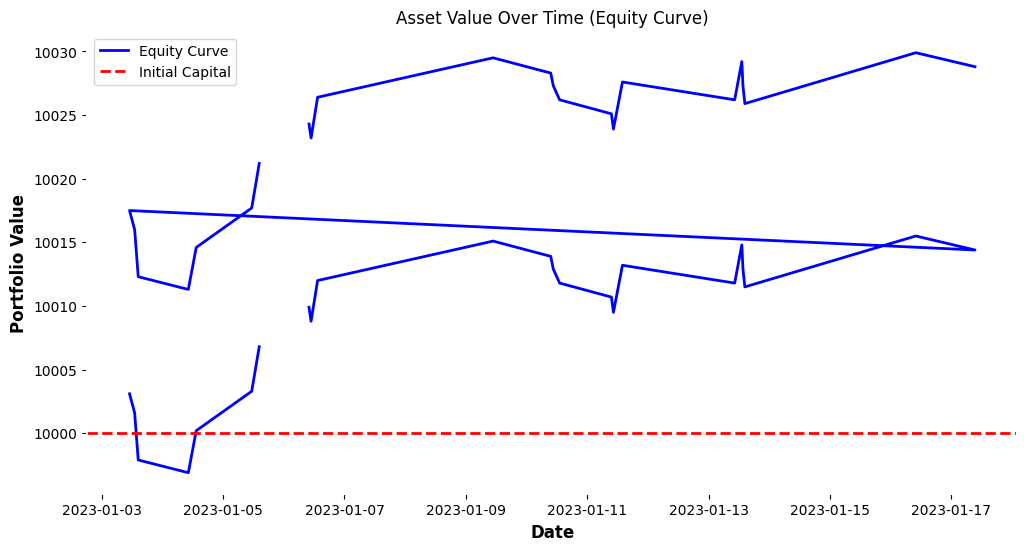

In [23]:
# Set initial capital
initial_capital = 10000  # Example starting balance

# Convert trades into a DataFrame
trades_df = pd.DataFrame(trades)

# Compute cumulative profit
trades_df["capital_over_time"] = initial_capital + trades_df["profit"].cumsum()

# Plot asset value over time
plt.figure(figsize=(12, 6))
plt.plot(trades_df["exit_time"], trades_df["capital_over_time"], label="Equity Curve", color="b")
plt.axhline(y=initial_capital, color="r", linestyle="--", label="Initial Capital")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.title("Asset Value Over Time (Equity Curve)")
plt.legend()
plt.grid()
plt.show()

### 4.2 Holding Period Return

We can also calculate the rate of return during the considered period

In [24]:
final_capital = initial_capital + trades_df["profit"].sum()

# Compute Holding Period Return
HPR = ((final_capital - initial_capital) / initial_capital) * 100

print(f"Holding Period Return (HPR): {HPR:.2f}%")

Holding Period Return (HPR): 0.29%


### 4.3 Maximum Drawdown (MDD)

Maximum Drawdown (MDD) is also a great tool for assessing the maximum theoretical risk. We can calculate the MDD below.

In [26]:
# Compute capital over time
trades_df["capital_over_time"] = initial_capital + trades_df["profit"].cumsum()

# Calculate the running maximum of the portfolio
running_max = trades_df["capital_over_time"].cummax()

# Compute Drawdown (Difference from peak)
drawdown = running_max - trades_df["capital_over_time"]

# Compute Maximum Drawdown (MDD)
max_drawdown = drawdown.max()

# Convert to percentage
MDD_percentage = (max_drawdown / running_max.max()) * 100

print(f"Maximum Drawdown (MDD): {MDD_percentage:.2f}%")

Maximum Drawdown (MDD): 0.06%


### 4.4 Sharpe ratio

We have shown that the `Sharpe Ratio` is also a great tool to evaluate the compromising between reward and risk. We show the `Sharpe Ratio` of the SMA Trading algorithm in this section.

In [34]:
if not trades:
    sharpe_ratio = "No trades executed, Sharpe Ratio cannot be calculated."
else:
    # Convert trade list to DataFrame
    trades_df = pd.DataFrame(trades)
    
    # Calculate daily returns from trade profits
    daily_return = trades_df['profit']

    # Define risk-free rate (e.g., 3% annualized for government bonds)
    risk_free_rate = 0.03

    # Compute Sharpe Ratio
    trading_days_per_year = 252
    annual_std = np.sqrt(trading_days_per_year) * np.std(daily_return)
    annual_return = trading_days_per_year * np.mean(daily_return) - risk_free_rate
    sharpe_ratio = annual_return / annual_std if annual_std != 0 else 0

sharpe_ratio


np.float64(4.106366361823632)